# Glauber with PBC

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, LaTeXStrings, Statistics, IndexedGraphs, Graphs, Random
import Measurements: value
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [205]:
N = 3
T = 30
J = 1.5
# h = 0.1
# m_eq = tanh(β*h + atanh(tanh(β*h)*tanh(β*J)))
# r_eq = tanh(β*J + atanh(tanh(β*h)*tanh(β*h)))
β = 1.0
seed = 1
rng = MersenneTwister(seed)
# gg = prufer_decode(rand(rng, 1:N, N-2))
gg = PathGraph(N)
colors = bipartite_map(gg)
Js = fill(J, ne(gg))
h = 0.5
hs = h*rand(rng, N)
ising = Ising(IndexedGraph(gg); J=Js, h=hs, β)
p0 = 0.5
w = map(vertices(gg)) do i
    map(0:T) do t
        DampedFactor(HomogeneousGlauberFactor(J, ising.h[i], β), p0)
    end
end
bp = mpbp(IndexedBiDiGraph(gg), w, fill(2,N), T)
cb = CB_BP(bp);

In [206]:
import IsingChains
x = IsingChains.IsingChain(Js, hs, β)
m_eq = IsingChains.site_magnetizations(x) |> mean
r_eq = IsingChains.neighbor_magnetizations(x) |> mean
m_eq, r_eq

(0.388711878834066, 0.911962782063034)

In [207]:
svd_trunc=TruncBondThresh(12,1e-10)
iters, cb = iterate!(bp; maxiter=100, svd_trunc, cb, tol=1e-6, periodic=true, damp=0.5);

Running MPBP: iter 36 	 Time: 0:03:43
  Δ:                  4.1297638753157173e-7
  SVD tolerance, m':  1.0e-10, 12

In [208]:
bond_dims.(bp.μ)

4-element Vector{Vector{Int64}}:
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

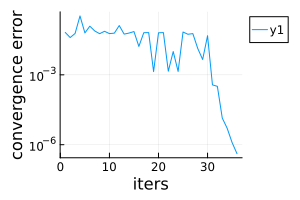

In [209]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, legend=:outertopright,
    size=(300,200))

In [210]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = means(spin, bp)
pb, logz = pair_beliefs(bp)
r = [[expectation(spin, bb) for bb in b] for b in pb];

In [211]:
sms = SoftMarginSampler(bp);

In [212]:
sample!(sms, 10^5)
m_mc_ = means(spin, sms)
m_mc = mean([value(x) for x in m] for m in m_mc_)
pm = pair_marginals(sms)
r_mc = mean([value.(expectation(spin, bb)) for bb in b] for b in pm);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:01
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:00
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:00


In [213]:
function params(p)
    J = 1/4*log(p[1]*p[4]/p[2]/p[3])
    h1 = 1/4*log(p[1]*p[2]/p[3]/p[4])
    h2 = 1/4*log(p[1]*p[3]/p[2]/p[4])
    logZ = -1/4*sum(log, p)
    J, h1, h2, logZ
end

params(mean(mean(pm)[end-1:end]))

(1.2762 ± 0.0021, 0.1416 ± 0.0021, 0.1416 ± 0.0021, 2.0811 ± 0.0021)

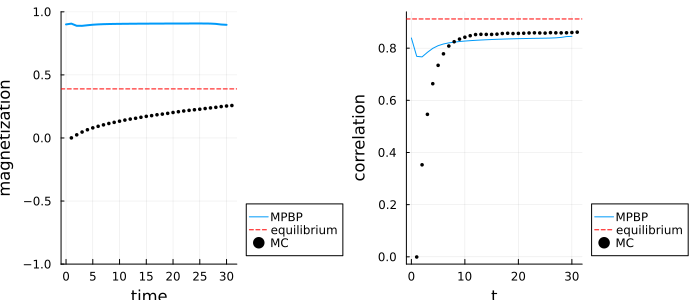

In [214]:
pl_m = plot(0:T, mean(m), lw=2, xlabel="time", ylabel="magnetization", msc=:auto,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP", ylims=(-1,1))
hline!(pl_m, [m_eq], c=:red, ls=:dash, lw=1, label="equilibrium", legend=:outerbottomright)
scatter!(pl_m, m_mc, label="MC", ms=2, c=:black)

pl_r = plot(0:T, mean(r) , label="MPBP", ylabel="correlation", xlabel="t")
hline!(pl_r, [r_eq], c=:red, ls=:dash, label="equilibrium")
scatter!(pl_r, r_mc, label="MC", ms=2, c=:black, legend=:outerbottomright)

plot(pl_m, pl_r, size=(700,300))

In [49]:
m_eq = equilibrium_magnetization(RandomRegular(k), J; β, h);

In [50]:
e_eq = equilibrium_energy(RandomRegular(k), J; β, h);

In [93]:
m⁰ = 0.0       # magnetization at time zero
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [94]:
matrix_sizes = [15]
maxiters = fill(30, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBondThresh(matrix_sizes[i],1e-10), cb, tol,
        periodic=true, damp=0.5)
end

Running MPBP: iter 8 	 Time: 0:00:56
  Δ:                  2.220446049250313e-16
  SVD tolerance, m':  1.0e-10, 15

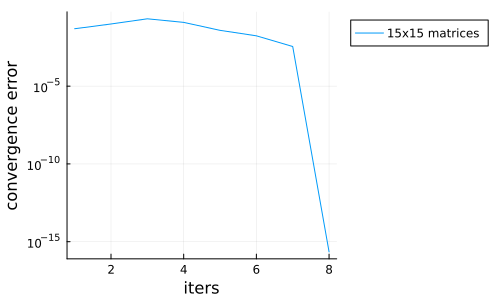

In [95]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

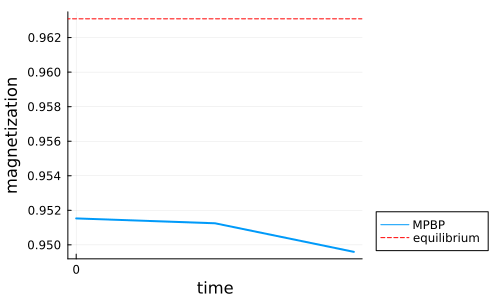

In [96]:
spin(x, i) = 3-2x
m = only(means(spin, bp))
pl = plot()
blue = theme_palette(:auto)[1]
plot!(pl, 0:T, m, lw=2, xlabel="time", ylabel="magnetization", msc=:auto, c=blue,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP")
hline!(pl, [m_eq], c=:red, ls=:dash, lw=1, label="equilibrium", legend=:outerbottomright)

In [97]:
pb, logz = pair_beliefs(bp)
spin(x) = spin(x, 0)
r = [[expectation(spin, bb) for bb in b] for b in pb];

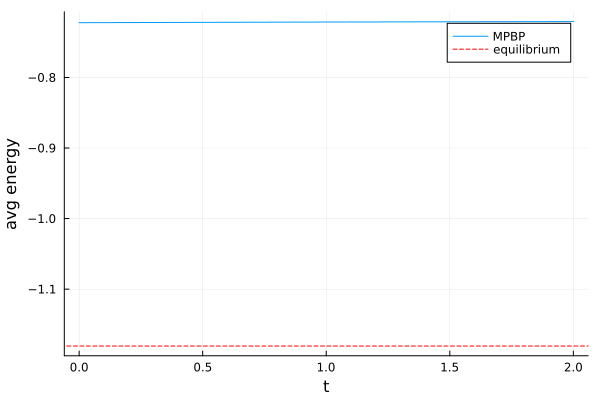

In [98]:
plot(0:T, -J*mean(r) .- h*mean(m), label="MPBP", ylabel="avg energy", xlabel="t")
hline!([e_eq], c=:red, ls=:dash, label="equilibrium")

In [43]:
using Graphs, IndexedGraphs, Statistics

N = 10^3
T_mc = 50
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T_mc))
sms = SoftMarginSampler(bp_mc);

In [44]:
sample!(sms, 50)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:01


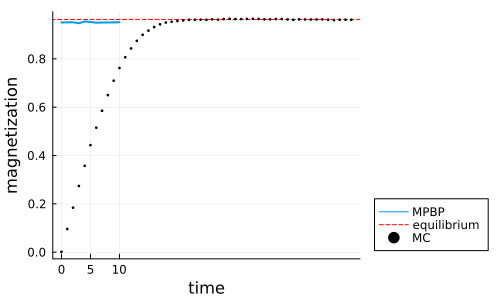

In [47]:
scatter!(deepcopy(pl), 0:T_mc, ms=1.5, mean(m_mc), label="MC", c=:black)